In [198]:
import numpy as np
import matplotlib.pyplot as plt

def wgn(signal, snr = 0):
    snr = 10 ** (snr / 10)
    xpower = np.sum(signal ** 2) / len(signal)
    npower = xpower / snr
    noise = np.random.randn(len(signal)) * np.sqrt(npower)
    return noise

def hilbert(signal, num_hilbert = 11):
    hilbert_transformer = np.zeros(num_hilbert, dtype=np.complex128)
    for i in range(-num_hilbert // 2, num_hilbert // 2 + 1, 1):
        if i % 2 == 0:
            hilbert_transformer[i + num_hilbert // 2] = 0
        else:
            hilbert_transformer[i + num_hilbert // 2] = 2j / (np.pi * i)

    hilbert_transformer[0 + num_hilbert // 2] = 1
    
    signal_hilbert = np.convolve(signal, hilbert_transformer, mode='same')
    
    return signal_hilbert

def pulse_compress(signal_src, signal_ref):
    signal_src_length = len(signal_src)
    signal_ref_length = len(signal_ref)
    

    fft_len = 2 * signal_src_length - 1
    fft_len = np.ceil(0.5 + np.log2(fft_len))
    fft_len = np.floor(0.5 + 2 ** fft_len)
    
    signal_ref = np.conjugate(signal_ref)
    signal_ref = np.flip(signal_ref)
    
    window = np.hamming(signal_ref_length)
    # signal_ref = signal_ref * window

    signal_src = np.pad(signal_src, (0, int(fft_len - signal_src_length)), 'constant')
    signal_ref = np.pad(signal_ref, (0, int(fft_len - signal_ref_length)), 'constant')
    
    signal_src_fft = np.fft.fft(signal_src, fft_len)
    signal_ref_fft = np.fft.fft(signal_ref, fft_len)
    
    signal_dst_fft = signal_src_fft * signal_ref_fft
    
    signal_dst = np.fft.ifft(signal_dst_fft, fft_len)
    
    return signal_dst

def lfm(tau, fs, fl, bw):
    times = np.linspace(0, tau - 1 / fs, int(tau * fs))
    phase = 2 * np.pi * fl * times + np.pi * bw / tau * times ** 2
    signal = np.exp(1j * phase)
    
    return signal


5.83510170540439 109.750589579201
0.5000953673053867 143.79900149161432
202.90564584272101


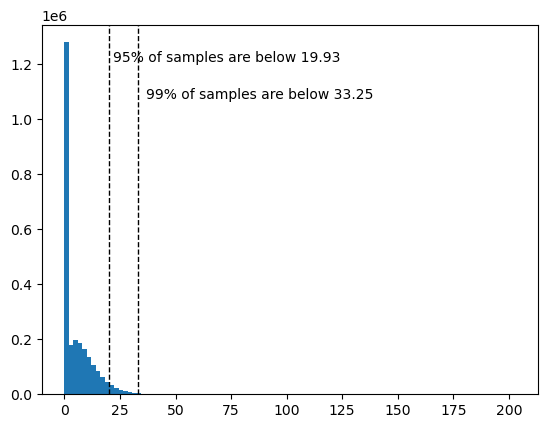

In [199]:
signal = np.real(lfm(7e-6, 20e6, 222e6, 6e6))

noise_samples = []

for _ in range(5000):
    noise = wgn(signal, 0)
    noise = hilbert(noise)
    noise = pulse_compress(noise, noise)
    
    noise_samples.extend(noise)

xpower = np.sum(signal ** 2) / len(signal)
npower = np.sum(np.abs(noise_samples) ** 2) / len(noise_samples)

# noise_samples = list(filter(lambda x: np.abs(x) > 0.1, noise_samples))

noise_samples = np.abs(noise_samples)

mean = np.mean(noise_samples)
var = np.var(noise_samples)
print(mean, var)
print(xpower, npower)
print(np.max(noise_samples))
plt.hist(noise_samples, bins=100)

percentile_95 = np.percentile(noise_samples, 95)
percentile_99 = np.percentile(noise_samples, 99)

# draw a line at 95% of the samples and mark the corresponding value
plt.axvline(percentile_95, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(percentile_95 * 1.1, max_ylim * 0.9, f'95% of samples are below {percentile_95:.2f}')

# 99%
plt.axvline(percentile_99, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(percentile_99 * 1.1, max_ylim * 0.8, f'99% of samples are below {percentile_99:.2f}')

plt.show()


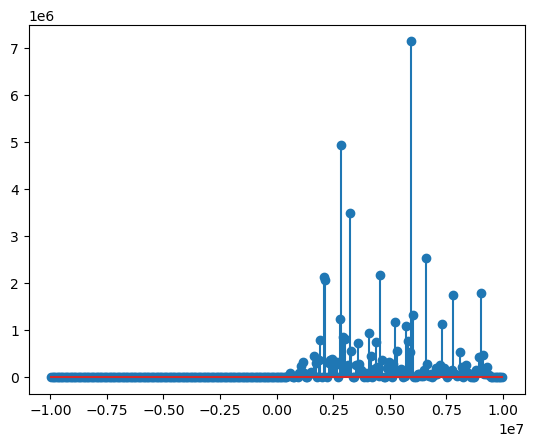

In [200]:
fft_len = 2 * len(signal) - 1

noise_hilbert = hilbert(noise)
noise_fft = np.fft.fft(noise_hilbert, fft_len)
noise_fftfreq = np.fft.fftfreq(fft_len, 1 / 20e6)
noise_power = np.abs(noise_fft) ** 2

# 正频率，散点图
plt.stem(noise_fftfreq, noise_power)
plt.show()


(0.006179489097668144-5.0306980803327406e-17j) 96.66238278160188


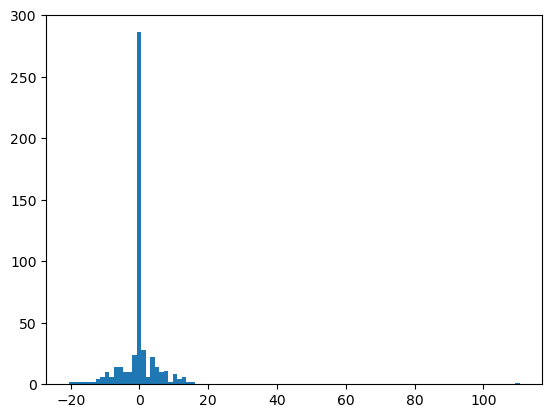

In [201]:
# 统计噪声的幅度值，绘制柱状图
mean = np.mean(noise)
var = np.var(noise)
print(mean, var)
plt.hist(noise, bins=100)
plt.show()

(0.3363645278625658-0.06277456378566544j) 66302.3900682931


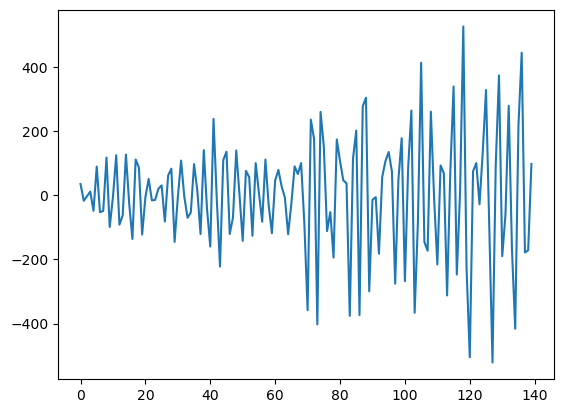

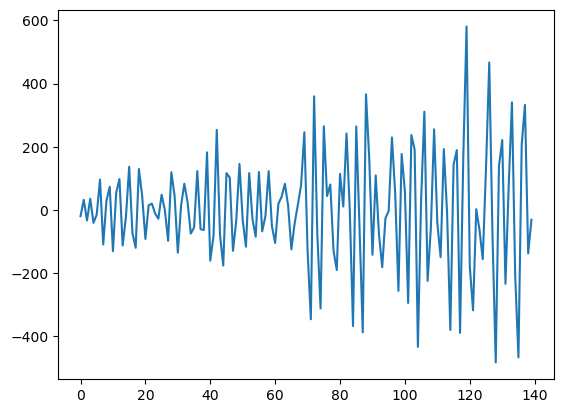

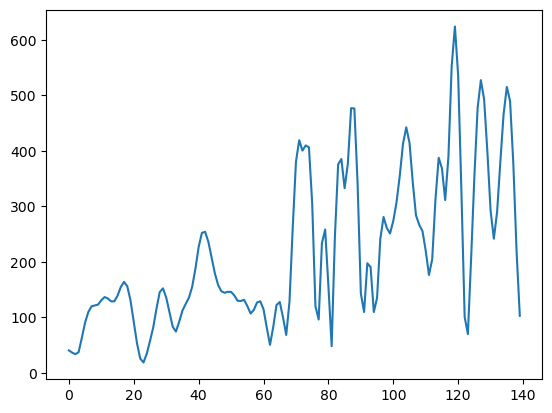

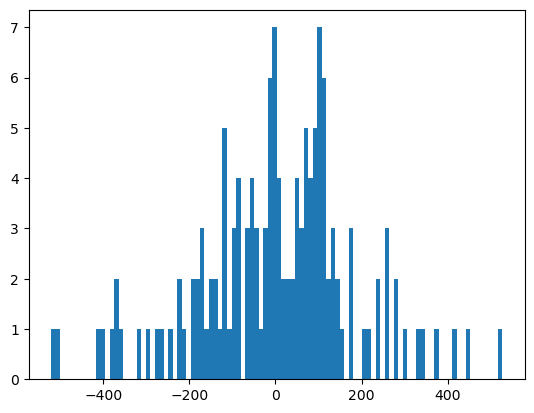

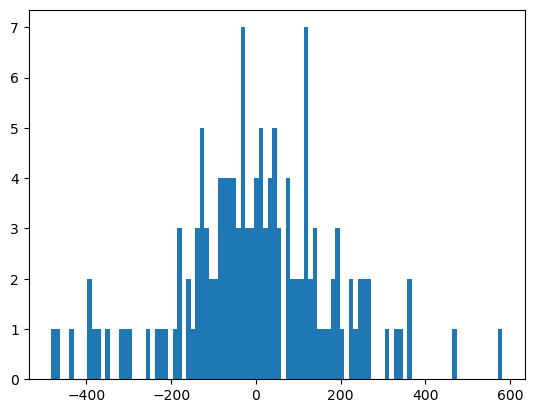

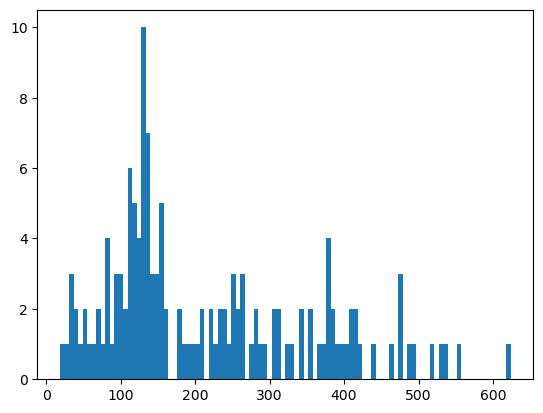

var_real: 33162.478070275894, var_imag: 33139.91199801719


In [202]:
signal_ref = np.real(lfm(7e-6, 20e6, 222e6, 6e6))

# noise_matched = pulse_compress(noise_hilbert, signal_ref)


fft_len = 2 * len(noise_hilbert) - 1
fft_len = np.ceil(0.5 + np.log2(fft_len))
fft_len = np.floor(0.5 + 2 ** fft_len)

signal_ref = np.conjugate(signal_ref)
signal_ref = np.flip(signal_ref)

window = np.hamming(len(noise_hilbert))
# signal_ref = signal_ref * window

# signal_ref = np.pad(signal_ref, (0, int(fft_len - len(noise_hilbert))), 'constant')
noise_pad = np.pad(noise_hilbert, (0, int(fft_len - len(noise_hilbert))), 'constant')

noise_matched = np.convolve(noise_pad, signal_ref, mode='same')

noise_matched = noise_matched[:len(signal)]

matched_mean = np.mean(noise_matched)
matched_var = np.var(noise_matched)

print(matched_mean, matched_var)

plt.plot(np.real(noise_matched))
plt.show()
plt.plot(np.imag(noise_matched))
plt.show()
plt.plot(np.abs(noise_matched))
plt.show()

plt.hist(np.real(noise_matched), bins=100)
plt.show()

plt.hist(np.imag(noise_matched), bins=100)
plt.show()
plt.hist(np.abs(noise_matched), bins=100)
plt.show()

var_real = np.var(np.real(noise_matched))
var_imag = np.var(np.imag(noise_matched))

print(f"var_real: {var_real}, var_imag: {var_imag}")